In [4]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

# Read dataset

In [42]:
import pickle as pkl
import json
import ast

"""
param:path of folder
return :data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y
"""
def load_data(path = "DataSet100/"):
    path_set = os.listdir(path)
    dataSet = []
    for filename in tqdm(path_set):
        #read features of constraints 
        cons_file = open(path+filename+"/constraints_features.json","rb")
        data = json.load(cons_file)
        data_cons = np.array(data["values"])
        nb_cons = data_cons.shape[0]
        cons_file.close()
        
        #read features of variables 
        var_file = open(path+filename+"/variables_features.json","rb")
        data = json.load(var_file)
        data_var = np.array(data["values"])
        nb_var = data_var.shape[0]
        var_file.close()
            #compose H
        data_cons = np.hstack((np.zeros((data_cons.shape[0],19)),data_cons))
        data_var = np.hstack((data_var,np.zeros((data_var.shape[0],5))))
        matrix_H = np.vstack((data_var,data_cons))
        
        #read label 
        label_file = open(path+filename+"/label.json","rb")
        data = json.load(label_file)
        bestSol = data["Best_Solution"]
        data_label = np.array(bestSol)
        label_file.close()
        #read edge
        edges_file = open(path+filename+"/edges_features.json","rb")
        data = json.load(edges_file)
        matrix_A = np.identity(nb_cons+nb_var)
        for i in range(len(data["values"])):
            iVar,iCons = data["indices"][1][i],data["indices"][0][i] 
            matrix_A[iVar][nb_var+iCons] = data["values"][i]
            matrix_A[iCons+nb_var][iVar] = data["values"][i]
        edges_file.close()
        dataSet.append({"X":matrix_H,"Y":data_label,"A":matrix_A})
        del data_cons
    return np.array(dataSet)
split = [0.70,0.15,0.15]
dataSet = load_data()
data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
# print(data_train_X.shape)
# print(data_train_Y.shape)
# print(A.shape)
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子

100%|███████████████████████████████████████████████████████████████████████████████| 900/900 [00:08<00:00, 110.47it/s]


# GCN






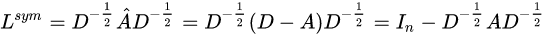

In [7]:
class simpleMLP(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(MLP, self).__init__()
        self.linear = nn.Linear(in_channel, out_channel)
        self.activate = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activate(x)
        return x
    
class Net(nn.Module):
    def __init__(self, in_channel,aux_channel,out_channel):
        super(Net,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            nn.ReLU(),
            nn.Linear(aux_channel, aux_channel),
        )
        self.mlp = MLP(in_channel, aux_channel)
        self.outlayer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            nn.ReLU(),
            nn.Linear(aux_channel, out_channel),
#             nn.LogSoftmax()
            nn.Sigmoid()
        )
    
    def forward(self, x, A,nb_net):
        x = self.mlp(x,A)
        for i in range(nb_net):
            x = self.layer(x)
        x = self.outlayer(x)
        return x
        
    

## Train


In [8]:
def train(model, x, y,A, optimizer,nb_net,criterion):
    optimizer.zero_grad()
    output = model(x,A,nb_net)[:len(y)].squeeze(dim=-1)
#     print("output",output)
    loss =criterion(output,y)
#     print("loss",loss)
    loss.backward()
    optimizer.step()

    return loss, output

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
nb_net = 3
EPOCHS = 200
net = Net(24,50,1)
net.to(device)
optm = Adam(net.parameters(), lr = 0.001)
criterion = nn.BCELoss()
# torch.cuda.get_device_name(device)
# print(next(net.parameters()).device)

cuda


In [40]:
net = Net(24,50,1)
net.to(device)
optm = Adam(net.parameters(), lr = 0.001)
for epoch in tqdm(range(EPOCHS)):
    #validation
    if epoch % 20 == 0:
        vloss = []
        accuracy_value = []
        accuracy_instance = []
        accuracy_one = []
        accuracy_zero = []
        accuracy_fixe = []
        proportion = 0.7
        data_size = len(data_validation)
        for i in range(data_size):
            inputs, labels = torch.from_numpy(data_validation[i]['X']).float(),torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
            A = torch.from_numpy(data_validation[i]['A']).float()
            inputs = inputs.to(device)
            labels = labels.to(device)
            A = A.to(device)
            loss, predictions = train(net,inputs,labels,A,optm,nb_net, criterion)
            aux= torch.Tensor([0.5]).to(device)
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == labels,1,0)
            vloss.append(loss.cpu().detach().numpy())
            accuracy_value.append(is_equal.cpu().sum().detach().numpy()/
                           len(labels))
            accuracy_instance.append(int(accuracy_value[-1]==1))

            #accuracy proportion
            nb_correct_fixe = 0
            predictions_abs = np.abs(predictions.cpu().detach().numpy())
            nb_var_fixe = int(proportion * len(predictions_abs))
            thresholds = np.sort(predictions_abs)[nb_var_fixe-1]
            #accuracy for differents labels(0 or 1)
            nb_correct_one = 0
            nb_correct_zero = 0
            for j,v in enumerate(is_equal):
                if labels[j] == 1:
                    nb_correct_one += v
                else:
                    nb_correct_zero += v

                if predictions_abs[j] <= thresholds:
                    nb_correct_fixe += v
            nb_one_total = torch.sum(torch.where(labels == 1,1,0)).cpu()
            accuracy_one.append((nb_correct_one/nb_one_total).cpu())
            accuracy_zero.append((nb_correct_zero/(len(predictions_abs) - nb_one_total)).cpu())
            accuracy_fixe.append(nb_correct_fixe.cpu()/nb_var_fixe)
        #     print(nb_correct_fixe.cpu(),nb_var_fixe)
        #         print(labels,"\n",predictions)
        #         print(labels[0:10],y_hat[0:10])
        print("Loss = %f,Accuracy_value = %f,Accuracy_instance = %f,Accuracy_one = %f,Accuracy_zeros = %f,,Accuracy_fixe = %f"\
              %(np.mean(vloss),np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance),np.mean(accuracy_one),np.mean(accuracy_zero),np.mean(accuracy_fixe)))

    #train
    for i in range(len(data_train)):
        valid_inputs, valid_labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_train[i]['A']).float()
        valid_inputs = valid_inputs.to(device)
        valid_labels = valid_labels.to(device)
        A = A.to(device)
        loss, predictions = train(net,valid_inputs,valid_labels,A,optm,nb_net, criterion)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Loss = 0.391589,Accuracy_value = 0.803744,Accuracy_instance = 0.000000,Accuracy_one = 0.192776,Accuracy_zeros = 0.818593,,Accuracy_fixe = 0.819229


 10%|████████                                                                         | 20/200 [02:21<17:51,  5.95s/it]

Loss = 0.052048,Accuracy_value = 0.984014,Accuracy_instance = 0.000000,Accuracy_one = 0.582930,Accuracy_zeros = 0.995122,,Accuracy_fixe = 0.998230


 20%|████████████████▏                                                                | 40/200 [04:42<15:34,  5.84s/it]

Loss = 0.051421,Accuracy_value = 0.984054,Accuracy_instance = 0.000000,Accuracy_one = 0.576657,Accuracy_zeros = 0.995330,,Accuracy_fixe = 0.998333


 20%|████████████████▌                                                                | 41/200 [05:17<20:30,  7.74s/it]


KeyboardInterrupt: 

In [43]:
path = "var100H50"
torch.save(net.state_dict(),path)

In [44]:
model = Net(24,50,1).to(device)
model.load_state_dict(torch.load(path))
model.eval()

Net(
  (layer): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
  (mlp): MLP(
    (linear): Linear(in_features=24, out_features=50, bias=True)
    (activate): ReLU()
  )
  (outlayer): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [48]:
# i = 0
import matplotlib as plot

vloss = []
accuracy_value = []
accuracy_instance = []
accuracy_one = []
accuracy_zero = []
accuracy_fixe = []
proportion = 0.8
data_size = len(data_validation)
for i in range(data_size):
    inputs, labels = torch.from_numpy(data_validation[i]['X']).float(),torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
    A = torch.from_numpy(data_validation[i]['A']).float()
    inputs = inputs.to(device)
    labels = labels.to(device)
    A = A.to(device)
    loss, predictions = train(net,inputs,labels,A,optm,nb_net, criterion)
    aux= torch.Tensor([0.5]).to(device)
    y_hat = (predictions > aux).float() * 1
    is_equal = torch.where(y_hat == labels,1,0)
    vloss.append(loss.cpu().detach().numpy())
    accuracy_value.append(is_equal.cpu().sum().detach().numpy()/
                   len(labels))
    accuracy_instance.append(int(accuracy_value[-1]==1))
    
    #accuracy proportion
    nb_correct_fixe = 0
    predictions_abs = np.abs(predictions.cpu().detach().numpy())
    nb_var_fixe = int(proportion * len(predictions_abs))
    thresholds = np.sort(predictions_abs)[nb_var_fixe-1]
    #accuracy for differents labels(0 or 1)
    nb_correct_one = 0
    nb_correct_zero = 0
    for j,v in enumerate(is_equal):
        if labels[j] == 1:
            nb_correct_one += v
        else:
            nb_correct_zero += v
            
        if predictions_abs[j] <= thresholds:
            nb_correct_fixe += v
    
    accuracy_one.append((nb_correct_one/torch.sum(torch.where(labels == 1,1,0))).cpu())
    accuracy_zero.append((nb_correct_zero/torch.sum(torch.where(labels == 0,1,0))).cpu())
    accuracy_fixe.append(nb_correct_fixe.cpu()/nb_var_fixe)
#     print(nb_correct_fixe.cpu(),nb_var_fixe)
#         print(labels,"\n",predictions)
#         print(labels[0:10],y_hat[0:10])
print("Loss = %f,Accuracy_value = %f,Accuracy_instance = %f,Accuracy_one = %f,Accuracy_zeros = %f,Accuracy_fixe = %f，%f"\
      %(np.mean(vloss),np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance),np.mean(accuracy_one),np.mean(accuracy_zero),np.mean(accuracy_fixe),len(np.where(accuracy_fixe !=1))))


Loss = 0.037494,Accuracy_value = 0.990716,Accuracy_instance = 0.770370,Accuracy_one = 0.952979,Accuracy_zeros = 0.994256,Accuracy_fixe = 0.999290，1.000000
[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.9833), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), 

[1.7798764e-26 7.0414002e-26 9.3615640e-26 1.5383472e-25 2.9148743e-25
 6.6009992e-25 8.7946158e-25 2.0242735e-24 2.3931243e-24 4.1087528e-24
 4.3704590e-24 9.7689442e-24 2.2532679e-23 3.1996328e-23 6.5626664e-23
 1.8506693e-22 2.0564512e-22 3.2699559e-22 4.9316085e-22 1.4182115e-21
 2.0394451e-21 2.8631397e-21 7.3625012e-21 1.0094449e-20 1.2350158e-20
 1.3149133e-20 1.3359717e-20 2.8441562e-20 3.1921036e-20 6.5421301e-20
 1.2122752e-19 1.4594244e-19 1.7358353e-19 3.0347592e-19 3.5023796e-19
 1.3362839e-18 2.0315980e-18 2.4861577e-18 4.9239489e-18 5.7315250e-18
 9.4311039e-18 1.0555207e-17 1.0760434e-17 7.3737030e-17 8.6064384e-17
 2.2354335e-16 3.4360056e-16 1.2033211e-15 1.4897341e-15 1.6745827e-15
 2.6811456e-15 3.4930603e-15 4.6040467e-15 5.3543324e-15 1.1496419e-14
 1.3527761e-14 2.7772943e-14 4.0452196e-14 4.0874503e-14 4.2679693e-14
 1.1927129e-13 1.2803387e-13 2.4768870e-13 3.0216343e-13 3.6925085e-13
 6.3391948e-12 1.0998490e-11 1.5111263e-11 4.0309381e-11 4.4360793e-11
 8.787

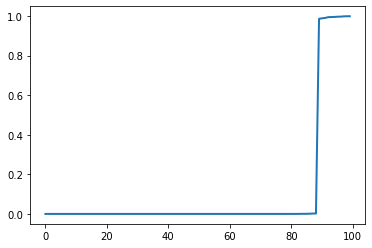

In [59]:
aux = predictions.cpu().detach().numpy()
fig, ax = plt.subplots()
print(np.sort(aux))
ax.plot(range(100), np.sort(aux), linewidth=2.0)
plt.show()

In [50]:
print(predictions)
print(is_equal)

tensor([3.5778e-07, 9.6174e-01, 4.0244e-03, 3.2602e-06, 1.0686e-05, 1.0525e-07,
        1.3008e-02, 9.4480e-01, 6.9885e-08, 1.4092e-08, 7.8429e-09, 4.8796e-03,
        8.1541e-08, 2.3813e-10, 3.6911e-06, 9.3336e-01, 1.8995e-08, 1.7730e-02,
        8.9215e-08, 8.1155e-11, 3.5725e-07, 4.4088e-09, 4.3797e-07, 5.0867e-07,
        1.1634e-08, 9.6774e-01, 1.3338e-10, 5.0136e-05, 5.9565e-08, 9.7451e-01,
        1.9345e-07, 1.7947e-04, 5.0948e-09, 6.7948e-06, 1.4866e-07, 2.3000e-06,
        5.9756e-08, 1.4319e-07, 6.8098e-07, 6.6191e-09, 1.2537e-04, 1.4203e-03,
        8.0534e-04, 5.1073e-05, 4.5276e-05, 2.2240e-06, 2.0379e-04, 3.7403e-02,
        9.3997e-01, 9.8739e-04, 3.0799e-06, 1.0677e-02, 1.7341e-04, 3.1508e-07,
        9.5547e-01, 2.0485e-03, 5.5784e-06, 2.5257e-02, 1.5110e-07, 9.6947e-10,
        4.5361e-10, 1.3881e-02, 8.2127e-03, 8.6181e-04, 7.8021e-06, 5.6190e-04,
        6.3739e-02, 9.7986e-01, 7.5177e-06, 3.3613e-06, 4.0292e-07, 2.5270e-03,
        9.6540e-08, 1.8202e-07, 7.4319e-

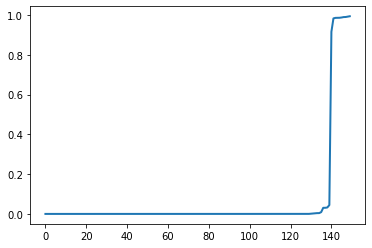

In [23]:
p = np.sort(np.abs(predictions.cpu().detach().numpy()))
fig, ax = plt.subplots()
ax.plot(range(150), p, linewidth=2.0)
plt.show()

array([2.29073576e-05, 2.93063367e-05, 3.03375982e-05, 3.11598924e-05,
       3.23385830e-05, 3.27126836e-05, 3.30558541e-05, 3.31437950e-05,
       3.58737852e-05, 3.75816453e-05, 3.82391772e-05, 3.83544357e-05,
       3.90589594e-05, 3.93755399e-05, 3.99274541e-05, 4.02713849e-05,
       4.06531108e-05, 4.10377579e-05, 4.11684814e-05, 4.15976901e-05,
       4.20327779e-05, 4.24290592e-05, 4.29528918e-05, 4.32200068e-05,
       4.34262038e-05, 4.35298607e-05, 4.41331395e-05, 4.46975646e-05,
       4.51299420e-05, 4.62914104e-05, 4.72585198e-05, 4.77069370e-05,
       4.79975715e-05, 4.81159441e-05, 4.91310129e-05, 4.98621957e-05,
       5.03013871e-05, 5.14680250e-05, 5.17566914e-05, 5.25878932e-05,
       5.26455406e-05, 5.28642850e-05, 5.40116525e-05, 5.41505324e-05,
       5.42638008e-05, 5.42659727e-05, 5.51028825e-05, 5.57315980e-05,
       5.68554569e-05, 5.75074591e-05, 5.76187267e-05, 5.77463979e-05,
       5.83146757e-05, 5.94194098e-05, 6.06602516e-05, 6.08320697e-05,
      